- [JONGGON/Mxnet_Tutorial](https://github.com/JONGGON/Mxnet_Tutorial)

- [动手学深度学习](http://zh.gluon.ai/index.html)

# 符号式编程

详细：[MXNet——symbol](https://www.cnblogs.com/q735613050/p/9315504.html)

In [17]:
f1 = '''
def add(a, b):
    return a + b
'''

f2 = '''
def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
'''

f3 = '''
print(fancy_func(1, 2, 3, 4))
'''

In [40]:
%%time
def add_str():
    return f1

def fancy_func_str():
    return f2

def evoke_str():
    return add_str() + fancy_func_str() + f3


prog = evoke_str()
print(prog)
y = compile(prog, '', 'exec')
exec(y)


def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g

print(fancy_func(1, 2, 3, 4))

10
Wall time: 996 µs


In [37]:
%%time
prog = f1 + f2 + f3
y = compile(prog, '', 'exec')
exec(y)

10
Wall time: 999 µs


# 混合式编程

在混合式编程中，我们可以通过使用 `HybridBlock` 或者 `HybridSequential` 类构建模型。默认情况下，它们和 `Block` 或者 `Sequential` 类一样依据命令式编程的方式执行。当我们调用 `hybridize` 函数后，Gluon 会转换成依据符号式编程的方式执行。事实上，绝大多数模型都可以享受符号式编程的优势。

In [1]:
from mxnet import nd, sym
from mxnet.gluon import nn

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [44]:
class CenteredLayer(nn.Block):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def forward(self, x):
        return x - x.mean()

## 符号变量

In [1]:
import mxnet as mx

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = mx.sym.Variable('c')

d = (a + b) * c

In [7]:
input_args = {
    'a': mx.nd.array([1]),
    'b': mx.nd.array([2]),
    'c': mx.nd.array([3])
}

In [8]:
executor = d.bind(ctx=mx.cpu(), args=input_args)

In [9]:
executor.forward()

[
 [9.]
 <NDArray 1 @cpu(0)>]

In [11]:
executor.outputs[0].asnumpy()

array([9.], dtype=float32)

## 求导

In [12]:
grad_a = mx.nd.empty(1)

In [13]:
executor = d.bind(
    ctx = mx.cpu(),
    args=input_args,
    args_grad={'a': grad_a}
)

In [14]:
executor.backward(out_grads=mx.nd.ones(1))

In [15]:
grad_a.asscalar()

3.0

# 读取数据

`mxnet.io.NDArrayIter` 用来生成一个用于遍历训练数据和对应标签的迭代器

## 生成数据

In [19]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sample', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


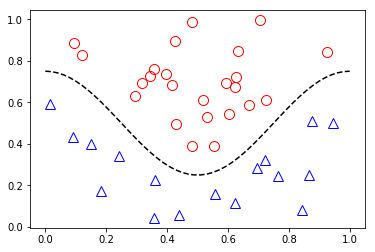

In [20]:
import pickle
import numpy as np
import matplotlib.pyplot as plt


def cos_curve(x):
    return 0.25*np.sin(2*x*np.pi+0.5*np.pi) + 0.5

np.random.seed(123)
samples = []
labels = []

sample_density = 50
for i in range(sample_density):
    x1, x2 = np.random.random(2)
    bound = cos_curve(x1)
    # 为了方便可视化，舍弃太靠近边界的样本
    if bound - 0.1 < x2 <= bound + 0.1:
        continue
    else:
        samples.append((x1, x2))
        if x2 > bound:
            labels.append(1)
        else:
            labels.append(0)

with open('data.pkl', 'wb') as f:
    pickle.dump((samples, labels), f)

for i, sample in enumerate(samples):
    plt.plot(sample[0], sample[1],
             'o' if labels[i] else '^',
             mec='r' if labels[i] else 'b',
             mfc='none',
             markersize=10)

x1 = np.linspace(0, 1)
plt.plot(x1, cos_curve(x1), 'k--')
plt.show()

# 构建神经网络

In [25]:
import pickle
import logging
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the network
data = mx.sym.Variable('data')
fc1 = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=2)
sigmoid1 = mx.sym.Activation(data=fc1, name='sigmoid1', act_type='sigmoid')
fc2 = mx.sym.FullyConnected(data=sigmoid1, name='fc2', num_hidden=2)
mlp = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

In [26]:
# 网络结构可视化
shape = {'data': (2,)}
mlp_dot = mx.viz.plot_network(symbol=mlp, shape=shape)
mlp_dot.render('simple_mlp.gv', view=True)  # 导出到本地

'simple_mlp.gv.pdf'

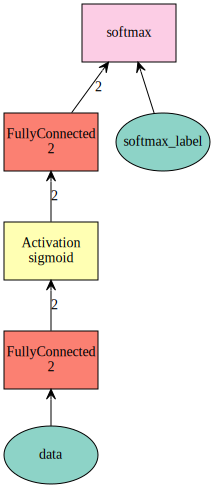

In [27]:
mlp_dot

In [61]:
# Load data & train the model
with open('data.pkl', 'rb') as f:
    samples, labels = pickle.load(f)

#  设置 logging 级别，显示训练时的信息
logging.getLogger().setLevel(logging.DEBUG)

batch_size = len(labels)
samples = np.array(samples)
labels = np.array(labels)

train_iter = mx.io.NDArrayIter(samples, labels, batch_size)

model = mx.model.FeedForward.create(
    symbol=mlp,
    X=train_iter,
    num_epoch=1000,
    learning_rate=0.1,
    momentum=0.99)
model.fit(train_iter)

print(model.predict(mx.io.NDArrayIter(mx.nd.array([[0.5, 0.5]]))))

C:\ProgramData\Anaconda3\lib\site-packages\mxnet\model.py:985: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  optimizer=optimizer, initializer=initializer, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\mxnet\model.py:572: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.005
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.006
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.004
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.004
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.003
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.004
INFO:root:Epoch[6] Resetting Data Iterato

INFO:root:Epoch[96] Time cost=0.004
INFO:root:Epoch[97] Resetting Data Iterator
INFO:root:Epoch[97] Time cost=0.003
INFO:root:Epoch[98] Resetting Data Iterator
INFO:root:Epoch[98] Time cost=0.003
INFO:root:Epoch[99] Resetting Data Iterator
INFO:root:Epoch[99] Time cost=0.004
INFO:root:Epoch[100] Resetting Data Iterator
INFO:root:Epoch[100] Time cost=0.004
INFO:root:Epoch[101] Resetting Data Iterator
INFO:root:Epoch[101] Time cost=0.003
INFO:root:Epoch[102] Resetting Data Iterator
INFO:root:Epoch[102] Time cost=0.016
INFO:root:Epoch[103] Resetting Data Iterator
INFO:root:Epoch[103] Time cost=0.009
INFO:root:Epoch[104] Resetting Data Iterator
INFO:root:Epoch[104] Time cost=0.009
INFO:root:Epoch[105] Resetting Data Iterator
INFO:root:Epoch[105] Time cost=0.018
INFO:root:Epoch[106] Resetting Data Iterator
INFO:root:Epoch[106] Time cost=0.009
INFO:root:Epoch[107] Resetting Data Iterator
INFO:root:Epoch[107] Time cost=0.004
INFO:root:Epoch[108] Resetting Data Iterator
INFO:root:Epoch[108] Ti

INFO:root:Epoch[196] Time cost=0.005
INFO:root:Epoch[197] Resetting Data Iterator
INFO:root:Epoch[197] Time cost=0.006
INFO:root:Epoch[198] Resetting Data Iterator
INFO:root:Epoch[198] Time cost=0.005
INFO:root:Epoch[199] Resetting Data Iterator
INFO:root:Epoch[199] Time cost=0.004
INFO:root:Epoch[200] Resetting Data Iterator
INFO:root:Epoch[200] Time cost=0.004
INFO:root:Epoch[201] Resetting Data Iterator
INFO:root:Epoch[201] Time cost=0.004
INFO:root:Epoch[202] Resetting Data Iterator
INFO:root:Epoch[202] Time cost=0.004
INFO:root:Epoch[203] Resetting Data Iterator
INFO:root:Epoch[203] Time cost=0.004
INFO:root:Epoch[204] Resetting Data Iterator
INFO:root:Epoch[204] Time cost=0.004
INFO:root:Epoch[205] Resetting Data Iterator
INFO:root:Epoch[205] Time cost=0.004
INFO:root:Epoch[206] Resetting Data Iterator
INFO:root:Epoch[206] Time cost=0.005
INFO:root:Epoch[207] Resetting Data Iterator
INFO:root:Epoch[207] Time cost=0.006
INFO:root:Epoch[208] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[296] Resetting Data Iterator
INFO:root:Epoch[296] Time cost=0.006
INFO:root:Epoch[297] Resetting Data Iterator
INFO:root:Epoch[297] Time cost=0.005
INFO:root:Epoch[298] Resetting Data Iterator
INFO:root:Epoch[298] Time cost=0.005
INFO:root:Epoch[299] Resetting Data Iterator
INFO:root:Epoch[299] Time cost=0.004
INFO:root:Epoch[300] Resetting Data Iterator
INFO:root:Epoch[300] Time cost=0.004
INFO:root:Epoch[301] Resetting Data Iterator
INFO:root:Epoch[301] Time cost=0.004
INFO:root:Epoch[302] Resetting Data Iterator
INFO:root:Epoch[302] Time cost=0.004
INFO:root:Epoch[303] Resetting Data Iterator
INFO:root:Epoch[303] Time cost=0.004
INFO:root:Epoch[304] Resetting Data Iterator
INFO:root:Epoch[304] Time cost=0.004
INFO:root:Epoch[305] Resetting Data Iterator
INFO:root:Epoch[305] Time cost=0.004
INFO:root:Epoch[306] Resetting Data Iterator
INFO:root:Epoch[306] Time cost=0.003
INFO:root:Epoch[307] Resetting Data Iterator
INFO:root:Epoch[307] Time cost=0.004
INFO:root:Epoch[

INFO:root:Epoch[396] Resetting Data Iterator
INFO:root:Epoch[396] Time cost=0.004
INFO:root:Epoch[397] Resetting Data Iterator
INFO:root:Epoch[397] Time cost=0.004
INFO:root:Epoch[398] Resetting Data Iterator
INFO:root:Epoch[398] Time cost=0.004
INFO:root:Epoch[399] Resetting Data Iterator
INFO:root:Epoch[399] Time cost=0.005
INFO:root:Epoch[400] Resetting Data Iterator
INFO:root:Epoch[400] Time cost=0.003
INFO:root:Epoch[401] Resetting Data Iterator
INFO:root:Epoch[401] Time cost=0.005
INFO:root:Epoch[402] Resetting Data Iterator
INFO:root:Epoch[402] Time cost=0.004
INFO:root:Epoch[403] Resetting Data Iterator
INFO:root:Epoch[403] Time cost=0.005
INFO:root:Epoch[404] Resetting Data Iterator
INFO:root:Epoch[404] Time cost=0.005
INFO:root:Epoch[405] Resetting Data Iterator
INFO:root:Epoch[405] Time cost=0.005
INFO:root:Epoch[406] Resetting Data Iterator
INFO:root:Epoch[406] Time cost=0.004
INFO:root:Epoch[407] Resetting Data Iterator
INFO:root:Epoch[407] Time cost=0.005
INFO:root:Epoch[

INFO:root:Epoch[496] Resetting Data Iterator
INFO:root:Epoch[496] Time cost=0.004
INFO:root:Epoch[497] Resetting Data Iterator
INFO:root:Epoch[497] Time cost=0.004
INFO:root:Epoch[498] Resetting Data Iterator
INFO:root:Epoch[498] Time cost=0.004
INFO:root:Epoch[499] Resetting Data Iterator
INFO:root:Epoch[499] Time cost=0.005
INFO:root:Epoch[500] Resetting Data Iterator
INFO:root:Epoch[500] Time cost=0.004
INFO:root:Epoch[501] Resetting Data Iterator
INFO:root:Epoch[501] Time cost=0.003
INFO:root:Epoch[502] Resetting Data Iterator
INFO:root:Epoch[502] Time cost=0.004
INFO:root:Epoch[503] Resetting Data Iterator
INFO:root:Epoch[503] Time cost=0.004
INFO:root:Epoch[504] Resetting Data Iterator
INFO:root:Epoch[504] Time cost=0.004
INFO:root:Epoch[505] Resetting Data Iterator
INFO:root:Epoch[505] Time cost=0.004
INFO:root:Epoch[506] Resetting Data Iterator
INFO:root:Epoch[506] Time cost=0.005
INFO:root:Epoch[507] Resetting Data Iterator
INFO:root:Epoch[507] Time cost=0.005
INFO:root:Epoch[

INFO:root:Epoch[596] Resetting Data Iterator
INFO:root:Epoch[596] Time cost=0.004
INFO:root:Epoch[597] Resetting Data Iterator
INFO:root:Epoch[597] Time cost=0.005
INFO:root:Epoch[598] Resetting Data Iterator
INFO:root:Epoch[598] Time cost=0.005
INFO:root:Epoch[599] Resetting Data Iterator
INFO:root:Epoch[599] Time cost=0.004
INFO:root:Epoch[600] Resetting Data Iterator
INFO:root:Epoch[600] Time cost=0.004
INFO:root:Epoch[601] Resetting Data Iterator
INFO:root:Epoch[601] Time cost=0.005
INFO:root:Epoch[602] Resetting Data Iterator
INFO:root:Epoch[602] Time cost=0.005
INFO:root:Epoch[603] Resetting Data Iterator
INFO:root:Epoch[603] Time cost=0.004
INFO:root:Epoch[604] Resetting Data Iterator
INFO:root:Epoch[604] Time cost=0.005
INFO:root:Epoch[605] Resetting Data Iterator
INFO:root:Epoch[605] Time cost=0.006
INFO:root:Epoch[606] Resetting Data Iterator
INFO:root:Epoch[606] Time cost=0.004
INFO:root:Epoch[607] Resetting Data Iterator
INFO:root:Epoch[607] Time cost=0.004
INFO:root:Epoch[

INFO:root:Epoch[696] Resetting Data Iterator
INFO:root:Epoch[696] Time cost=0.003
INFO:root:Epoch[697] Resetting Data Iterator
INFO:root:Epoch[697] Time cost=0.005
INFO:root:Epoch[698] Resetting Data Iterator
INFO:root:Epoch[698] Time cost=0.003
INFO:root:Epoch[699] Resetting Data Iterator
INFO:root:Epoch[699] Time cost=0.005
INFO:root:Epoch[700] Resetting Data Iterator
INFO:root:Epoch[700] Time cost=0.006
INFO:root:Epoch[701] Resetting Data Iterator
INFO:root:Epoch[701] Time cost=0.005
INFO:root:Epoch[702] Resetting Data Iterator
INFO:root:Epoch[702] Time cost=0.010
INFO:root:Epoch[703] Resetting Data Iterator
INFO:root:Epoch[703] Time cost=0.004
INFO:root:Epoch[704] Resetting Data Iterator
INFO:root:Epoch[704] Time cost=0.010
INFO:root:Epoch[705] Resetting Data Iterator
INFO:root:Epoch[705] Time cost=0.004
INFO:root:Epoch[706] Resetting Data Iterator
INFO:root:Epoch[706] Time cost=0.003
INFO:root:Epoch[707] Resetting Data Iterator
INFO:root:Epoch[707] Time cost=0.004
INFO:root:Epoch[

INFO:root:Epoch[796] Resetting Data Iterator
INFO:root:Epoch[796] Time cost=0.004
INFO:root:Epoch[797] Resetting Data Iterator
INFO:root:Epoch[797] Time cost=0.003
INFO:root:Epoch[798] Resetting Data Iterator
INFO:root:Epoch[798] Time cost=0.004
INFO:root:Epoch[799] Resetting Data Iterator
INFO:root:Epoch[799] Time cost=0.005
INFO:root:Epoch[800] Resetting Data Iterator
INFO:root:Epoch[800] Time cost=0.004
INFO:root:Epoch[801] Resetting Data Iterator
INFO:root:Epoch[801] Time cost=0.004
INFO:root:Epoch[802] Resetting Data Iterator
INFO:root:Epoch[802] Time cost=0.004
INFO:root:Epoch[803] Resetting Data Iterator
INFO:root:Epoch[803] Time cost=0.004
INFO:root:Epoch[804] Resetting Data Iterator
INFO:root:Epoch[804] Time cost=0.004
INFO:root:Epoch[805] Resetting Data Iterator
INFO:root:Epoch[805] Time cost=0.005
INFO:root:Epoch[806] Resetting Data Iterator
INFO:root:Epoch[806] Time cost=0.007
INFO:root:Epoch[807] Resetting Data Iterator
INFO:root:Epoch[807] Time cost=0.004
INFO:root:Epoch[

INFO:root:Epoch[896] Resetting Data Iterator
INFO:root:Epoch[896] Time cost=0.004
INFO:root:Epoch[897] Resetting Data Iterator
INFO:root:Epoch[897] Time cost=0.004
INFO:root:Epoch[898] Resetting Data Iterator
INFO:root:Epoch[898] Time cost=0.004
INFO:root:Epoch[899] Resetting Data Iterator
INFO:root:Epoch[899] Time cost=0.005
INFO:root:Epoch[900] Resetting Data Iterator
INFO:root:Epoch[900] Time cost=0.003
INFO:root:Epoch[901] Resetting Data Iterator
INFO:root:Epoch[901] Time cost=0.005
INFO:root:Epoch[902] Resetting Data Iterator
INFO:root:Epoch[902] Time cost=0.004
INFO:root:Epoch[903] Resetting Data Iterator
INFO:root:Epoch[903] Time cost=0.006
INFO:root:Epoch[904] Resetting Data Iterator
INFO:root:Epoch[904] Time cost=0.004
INFO:root:Epoch[905] Resetting Data Iterator
INFO:root:Epoch[905] Time cost=0.004
INFO:root:Epoch[906] Resetting Data Iterator
INFO:root:Epoch[906] Time cost=0.005
INFO:root:Epoch[907] Resetting Data Iterator
INFO:root:Epoch[907] Time cost=0.005
INFO:root:Epoch[

INFO:root:Epoch[996] Resetting Data Iterator
INFO:root:Epoch[996] Time cost=0.004
INFO:root:Epoch[997] Resetting Data Iterator
INFO:root:Epoch[997] Time cost=0.004
INFO:root:Epoch[998] Resetting Data Iterator
INFO:root:Epoch[998] Time cost=0.006
INFO:root:Epoch[999] Resetting Data Iterator
INFO:root:Epoch[999] Time cost=0.005
INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.004
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.004
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.004
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.007
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.003
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.004
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.004
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.004
INFO:root

INFO:root:Epoch[98] Time cost=0.004
INFO:root:Epoch[99] Resetting Data Iterator
INFO:root:Epoch[99] Time cost=0.003
INFO:root:Epoch[100] Resetting Data Iterator
INFO:root:Epoch[100] Time cost=0.005
INFO:root:Epoch[101] Resetting Data Iterator
INFO:root:Epoch[101] Time cost=0.004
INFO:root:Epoch[102] Resetting Data Iterator
INFO:root:Epoch[102] Time cost=0.004
INFO:root:Epoch[103] Resetting Data Iterator
INFO:root:Epoch[103] Time cost=0.003
INFO:root:Epoch[104] Resetting Data Iterator
INFO:root:Epoch[104] Time cost=0.004
INFO:root:Epoch[105] Resetting Data Iterator
INFO:root:Epoch[105] Time cost=0.004
INFO:root:Epoch[106] Resetting Data Iterator
INFO:root:Epoch[106] Time cost=0.004
INFO:root:Epoch[107] Resetting Data Iterator
INFO:root:Epoch[107] Time cost=0.004
INFO:root:Epoch[108] Resetting Data Iterator
INFO:root:Epoch[108] Time cost=0.004
INFO:root:Epoch[109] Resetting Data Iterator
INFO:root:Epoch[109] Time cost=0.004
INFO:root:Epoch[110] Resetting Data Iterator
INFO:root:Epoch[110

INFO:root:Epoch[198] Time cost=0.007
INFO:root:Epoch[199] Resetting Data Iterator
INFO:root:Epoch[199] Time cost=0.003
INFO:root:Epoch[200] Resetting Data Iterator
INFO:root:Epoch[200] Time cost=0.006
INFO:root:Epoch[201] Resetting Data Iterator
INFO:root:Epoch[201] Time cost=0.005
INFO:root:Epoch[202] Resetting Data Iterator
INFO:root:Epoch[202] Time cost=0.005
INFO:root:Epoch[203] Resetting Data Iterator
INFO:root:Epoch[203] Time cost=0.005
INFO:root:Epoch[204] Resetting Data Iterator
INFO:root:Epoch[204] Time cost=0.006
INFO:root:Epoch[205] Resetting Data Iterator
INFO:root:Epoch[205] Time cost=0.004
INFO:root:Epoch[206] Resetting Data Iterator
INFO:root:Epoch[206] Time cost=0.004
INFO:root:Epoch[207] Resetting Data Iterator
INFO:root:Epoch[207] Time cost=0.006
INFO:root:Epoch[208] Resetting Data Iterator
INFO:root:Epoch[208] Time cost=0.004
INFO:root:Epoch[209] Resetting Data Iterator
INFO:root:Epoch[209] Time cost=0.005
INFO:root:Epoch[210] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[298] Time cost=0.004
INFO:root:Epoch[299] Resetting Data Iterator
INFO:root:Epoch[299] Time cost=0.006
INFO:root:Epoch[300] Resetting Data Iterator
INFO:root:Epoch[300] Time cost=0.004
INFO:root:Epoch[301] Resetting Data Iterator
INFO:root:Epoch[301] Time cost=0.004
INFO:root:Epoch[302] Resetting Data Iterator
INFO:root:Epoch[302] Time cost=0.004
INFO:root:Epoch[303] Resetting Data Iterator
INFO:root:Epoch[303] Time cost=0.005
INFO:root:Epoch[304] Resetting Data Iterator
INFO:root:Epoch[304] Time cost=0.006
INFO:root:Epoch[305] Resetting Data Iterator
INFO:root:Epoch[305] Time cost=0.003
INFO:root:Epoch[306] Resetting Data Iterator
INFO:root:Epoch[306] Time cost=0.005
INFO:root:Epoch[307] Resetting Data Iterator
INFO:root:Epoch[307] Time cost=0.003
INFO:root:Epoch[308] Resetting Data Iterator
INFO:root:Epoch[308] Time cost=0.003
INFO:root:Epoch[309] Resetting Data Iterator
INFO:root:Epoch[309] Time cost=0.006
INFO:root:Epoch[310] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[398] Time cost=0.010
INFO:root:Epoch[399] Resetting Data Iterator
INFO:root:Epoch[399] Time cost=0.005
INFO:root:Epoch[400] Resetting Data Iterator
INFO:root:Epoch[400] Time cost=0.004
INFO:root:Epoch[401] Resetting Data Iterator
INFO:root:Epoch[401] Time cost=0.006
INFO:root:Epoch[402] Resetting Data Iterator
INFO:root:Epoch[402] Time cost=0.004
INFO:root:Epoch[403] Resetting Data Iterator
INFO:root:Epoch[403] Time cost=0.006
INFO:root:Epoch[404] Resetting Data Iterator
INFO:root:Epoch[404] Time cost=0.005
INFO:root:Epoch[405] Resetting Data Iterator
INFO:root:Epoch[405] Time cost=0.004
INFO:root:Epoch[406] Resetting Data Iterator
INFO:root:Epoch[406] Time cost=0.004
INFO:root:Epoch[407] Resetting Data Iterator
INFO:root:Epoch[407] Time cost=0.005
INFO:root:Epoch[408] Resetting Data Iterator
INFO:root:Epoch[408] Time cost=0.005
INFO:root:Epoch[409] Resetting Data Iterator
INFO:root:Epoch[409] Time cost=0.004
INFO:root:Epoch[410] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[498] Time cost=0.004
INFO:root:Epoch[499] Resetting Data Iterator
INFO:root:Epoch[499] Time cost=0.005
INFO:root:Epoch[500] Resetting Data Iterator
INFO:root:Epoch[500] Time cost=0.005
INFO:root:Epoch[501] Resetting Data Iterator
INFO:root:Epoch[501] Time cost=0.006
INFO:root:Epoch[502] Resetting Data Iterator
INFO:root:Epoch[502] Time cost=0.004
INFO:root:Epoch[503] Resetting Data Iterator
INFO:root:Epoch[503] Time cost=0.003
INFO:root:Epoch[504] Resetting Data Iterator
INFO:root:Epoch[504] Time cost=0.005
INFO:root:Epoch[505] Resetting Data Iterator
INFO:root:Epoch[505] Time cost=0.004
INFO:root:Epoch[506] Resetting Data Iterator
INFO:root:Epoch[506] Time cost=0.004
INFO:root:Epoch[507] Resetting Data Iterator
INFO:root:Epoch[507] Time cost=0.004
INFO:root:Epoch[508] Resetting Data Iterator
INFO:root:Epoch[508] Time cost=0.004
INFO:root:Epoch[509] Resetting Data Iterator
INFO:root:Epoch[509] Time cost=0.005
INFO:root:Epoch[510] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[598] Time cost=0.004
INFO:root:Epoch[599] Resetting Data Iterator
INFO:root:Epoch[599] Time cost=0.004
INFO:root:Epoch[600] Resetting Data Iterator
INFO:root:Epoch[600] Time cost=0.004
INFO:root:Epoch[601] Resetting Data Iterator
INFO:root:Epoch[601] Time cost=0.004
INFO:root:Epoch[602] Resetting Data Iterator
INFO:root:Epoch[602] Time cost=0.003
INFO:root:Epoch[603] Resetting Data Iterator
INFO:root:Epoch[603] Time cost=0.003
INFO:root:Epoch[604] Resetting Data Iterator
INFO:root:Epoch[604] Time cost=0.005
INFO:root:Epoch[605] Resetting Data Iterator
INFO:root:Epoch[605] Time cost=0.004
INFO:root:Epoch[606] Resetting Data Iterator
INFO:root:Epoch[606] Time cost=0.004
INFO:root:Epoch[607] Resetting Data Iterator
INFO:root:Epoch[607] Time cost=0.004
INFO:root:Epoch[608] Resetting Data Iterator
INFO:root:Epoch[608] Time cost=0.006
INFO:root:Epoch[609] Resetting Data Iterator
INFO:root:Epoch[609] Time cost=0.004
INFO:root:Epoch[610] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[698] Time cost=0.005
INFO:root:Epoch[699] Resetting Data Iterator
INFO:root:Epoch[699] Time cost=0.004
INFO:root:Epoch[700] Resetting Data Iterator
INFO:root:Epoch[700] Time cost=0.004
INFO:root:Epoch[701] Resetting Data Iterator
INFO:root:Epoch[701] Time cost=0.007
INFO:root:Epoch[702] Resetting Data Iterator
INFO:root:Epoch[702] Time cost=0.004
INFO:root:Epoch[703] Resetting Data Iterator
INFO:root:Epoch[703] Time cost=0.008
INFO:root:Epoch[704] Resetting Data Iterator
INFO:root:Epoch[704] Time cost=0.004
INFO:root:Epoch[705] Resetting Data Iterator
INFO:root:Epoch[705] Time cost=0.005
INFO:root:Epoch[706] Resetting Data Iterator
INFO:root:Epoch[706] Time cost=0.006
INFO:root:Epoch[707] Resetting Data Iterator
INFO:root:Epoch[707] Time cost=0.004
INFO:root:Epoch[708] Resetting Data Iterator
INFO:root:Epoch[708] Time cost=0.006
INFO:root:Epoch[709] Resetting Data Iterator
INFO:root:Epoch[709] Time cost=0.004
INFO:root:Epoch[710] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[798] Time cost=0.004
INFO:root:Epoch[799] Resetting Data Iterator
INFO:root:Epoch[799] Time cost=0.003
INFO:root:Epoch[800] Resetting Data Iterator
INFO:root:Epoch[800] Time cost=0.005
INFO:root:Epoch[801] Resetting Data Iterator
INFO:root:Epoch[801] Time cost=0.004
INFO:root:Epoch[802] Resetting Data Iterator
INFO:root:Epoch[802] Time cost=0.005
INFO:root:Epoch[803] Resetting Data Iterator
INFO:root:Epoch[803] Time cost=0.004
INFO:root:Epoch[804] Resetting Data Iterator
INFO:root:Epoch[804] Time cost=0.004
INFO:root:Epoch[805] Resetting Data Iterator
INFO:root:Epoch[805] Time cost=0.004
INFO:root:Epoch[806] Resetting Data Iterator
INFO:root:Epoch[806] Time cost=0.004
INFO:root:Epoch[807] Resetting Data Iterator
INFO:root:Epoch[807] Time cost=0.004
INFO:root:Epoch[808] Resetting Data Iterator
INFO:root:Epoch[808] Time cost=0.004
INFO:root:Epoch[809] Resetting Data Iterator
INFO:root:Epoch[809] Time cost=0.007
INFO:root:Epoch[810] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[898] Time cost=0.004
INFO:root:Epoch[899] Resetting Data Iterator
INFO:root:Epoch[899] Time cost=0.003
INFO:root:Epoch[900] Resetting Data Iterator
INFO:root:Epoch[900] Time cost=0.005
INFO:root:Epoch[901] Resetting Data Iterator
INFO:root:Epoch[901] Time cost=0.007
INFO:root:Epoch[902] Resetting Data Iterator
INFO:root:Epoch[902] Time cost=0.003
INFO:root:Epoch[903] Resetting Data Iterator
INFO:root:Epoch[903] Time cost=0.003
INFO:root:Epoch[904] Resetting Data Iterator
INFO:root:Epoch[904] Time cost=0.005
INFO:root:Epoch[905] Resetting Data Iterator
INFO:root:Epoch[905] Time cost=0.004
INFO:root:Epoch[906] Resetting Data Iterator
INFO:root:Epoch[906] Time cost=0.004
INFO:root:Epoch[907] Resetting Data Iterator
INFO:root:Epoch[907] Time cost=0.007
INFO:root:Epoch[908] Resetting Data Iterator
INFO:root:Epoch[908] Time cost=0.004
INFO:root:Epoch[909] Resetting Data Iterator
INFO:root:Epoch[909] Time cost=0.005
INFO:root:Epoch[910] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[998] Time cost=0.005
INFO:root:Epoch[999] Resetting Data Iterator
INFO:root:Epoch[999] Time cost=0.003


[[0.41328523 0.5867148 ]]


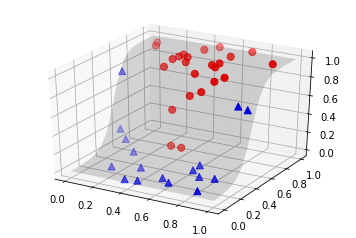

In [62]:
# Visualize result
X = np.arange(0, 1.05, 0.05)
Y = np.arange(0, 1.05, 0.05)
X, Y = np.meshgrid(X, Y)

grids = mx.nd.array([[X[i][j], Y[i][j]] for i in range(X.shape[0]) for j in range(X.shape[1])])
grid_probs = model.predict(grids)[:, 1].reshape(X.shape)

fig = plt.figure('Sample Surface')
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, grid_probs, alpha=0.15, color='k', rstride=2, cstride=2, lw=0.5)
samples0 = samples[labels==0]
samples0_probs = model.predict(samples0)[:, 1]
samples1 = samples[labels==1]
samples1_probs = model.predict(samples1)[:, 1]

ax.scatter(samples0[:, 0], samples0[:, 1], samples0_probs, c='b', marker='^', s=50)
ax.scatter(samples1[:, 0], samples1[:, 1], samples1_probs, c='r', marker='o', s=50)

plt.show()